In [1]:
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import transforms as t
import classifiers as clsf

import multiprocessing
n_cores = multiprocessing.cpu_count()
print(f'Number of cores to use: ', n_cores)

np.random.seed(69)

Number of cores to use:  4


# Data Preprocessing

In [2]:
train_df0 = pd.read_csv('train.csv')
# Y0 are new labels (maybe smoothed or with regression), Y_c0 are original class labels
X0_df, Y_c0, Y0 = t.transform_df(train_df0, train=True, as_df=True, k=None)
X0 = X0_df.values
(N, d) = X0.shape

# Model Selection

### Grid Search

In [3]:
### Just gonna take a random 10th for validation
X, valX, Y, valY = train_test_split(X0, Y0, shuffle=True, test_size=0.1)
pars = t.get_pars_for_processing(X)
X, valX = t.process_with_pars(X, pars), t.process_with_pars(valX, pars)

frac = 1 / 4
t_size, v_size = int(X.shape[0] * frac), int(valX.shape[0] * frac)
train_res, test_res, models = clsf.TuneClassifiers(X[:t_size], valX[:v_size], Y[:t_size], valY[:v_size], \
                                                   algs=['RF'])
test_res

Tuning RF ...
Tuned in: 168.0746738910675
{'max_features': 0.5, 'min_samples_leaf': 50, 'n_estimators': 50}


,Classifier,Type,Tuning,Accuracy,AUC
1,RF,test,base,0.650280,0.643648
3,RF,test,tuned,0.650145,0.649080


### Save best pars

In [4]:
parFName = 'best_pars.pars'
with open(parFName, 'wb') as f:
    pickle.dump({m:model.best_params_ for m, model in models.items()}, f)
    
with open(parFName, 'rb') as f:
    best_pars = pickle.load(f)

### Cross Validation

In [5]:
clf = RandomForestClassifier(**models['RF'].best_params_)
#clf = AdaBoostClassifier(**models['ADB'].best_params_)
#clf = GradientBoostingClassifier(**models['GDB'].best_params_)
aucs, accs = clsf.cross_val(clf, X0, Y0, (t.get_pars_for_processing, t.process_with_pars))
aucs.mean(), accs.mean()

CV fold: 3it [01:33, 31.28s/it]


(0.6461514446053016, 0.6559691414294878)

# Final Fitting

In [6]:
# Maybe parallelize
if 'n_jobs' in clf.get_params():
    clf.set_params(n_jobs=n_cores)

pars = t.get_pars_for_processing(X0)
process = lambda x: t.process_with_pars(x, pars)
X = process(X0)
clf.fit(X, Y0);

### Save Model

In [7]:
fName = datetime.today().strftime('%y%m%d_%H%M') + "_model.pkl"

with open(fName, 'wb') as f:
    pickle.dump(clf, f)
    
with open(fName, 'rb') as f:
    clf = pickle.load(f)

### Feature Importances

In [8]:
inds = np.array(sorted(range(len(X0_df.columns)), \
                       key=lambda x: clf.feature_importances_[x], \
                       reverse=True))
imp_dict = dict(zip(X0_df.columns[inds], clf.feature_importances_[inds]))
imp_dict

{'ask_w1': 0.23084373296416566,
 'bid_w1': 0.16158739233290795,
 'last_price': 0.08768326957530859,
 'ask_w5': 0.059583137680371795,
 'bid_w5': 0.058900285852323354,
 'ask_w3': 0.055677819701738844,
 'ask_w4': 0.0556718746502275,
 'bid_w4': 0.05547198407218943,
 'ask_w2': 0.05372688340495614,
 'bid_w3': 0.0525947639758496,
 'bid_w2': 0.05080539130564572,
 'transacted_qty': 0.032564149341110835,
 'closed_position_qty': 0.02158221520228374,
 'd_open_interest': 0.013600961126900764,
 'opened_position_qty ': 0.009706138814020007}

### Final train performance (on original labels)

In [9]:
auc(Y_c0, clf.predict_proba(X)[:,1]) # Get auc on original labels

0.7404761926909166

In [12]:
(clf.predict(X) == Y0).mean()

0.6946942840744117

# Get Predictions on Test Set

In [10]:
test_df0 = pd.read_csv('test.csv')
tX = t.transform_df(test_df0)
tX = process(tX)

output = clf.predict_proba(tX)[:, 1]
     
output_df = pd.DataFrame({'id':test_df0['id'], 'Predicted': output})
output_df.to_csv(f"submission_{datetime.today().strftime('%y%m%d_%H%M')}.csv", index=False)

### Sanity checks on output

mean of train_labels: 0.3569583713157095
mean of train_preds: 0.3821210009399781


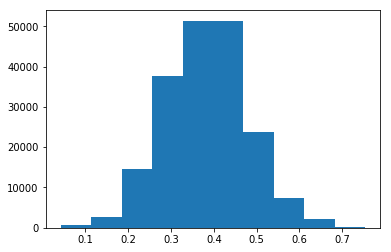

In [11]:
assert(np.all((0 <= output) & (output <= 1)))
print(f'mean of train_labels: {np.mean(Y_c0)}')
print(f'mean of train_preds: {np.mean(output)}')
plt.hist(output);